https://www.kaggle.com/chocozzz/pubg-data-description-a-to-z-fe-with-python

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test_V2.csv', 'train_V2.csv', 'sample_submission_V2.csv']


In [2]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import gc

import warnings
warnings.filterwarnings('ignore')


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

In [3]:
train = pd.read_csv('../input/train_V2.csv')
test = pd.read_csv('../input/test_V2.csv')

In [4]:
print('Train shape : ', train.shape)
print('Test shape : ', test.shape)

Train shape :  (4446966, 29)
Test shape :  (1934174, 28)


In [5]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [6]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%
Memory usage of dataframe is 413.18 MB
Memory usage after optimization is: 121.74 MB
Decreased by 70.5%


# EDA
## Missing Values
### Train

In [7]:
train.isnull().sum().sort_values(ascending = False)

winPlacePerc       1
longestKill        0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
matchDuration      0
winPoints          0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
Id                 0
dtype: int64

In [8]:
#NA개수 빼고 데이터가 몇갠지 보여줌
train.count()

Id                 4446966
groupId            4446966
matchId            4446966
assists            4446966
boosts             4446966
damageDealt        4446966
DBNOs              4446966
headshotKills      4446966
heals              4446966
killPlace          4446966
killPoints         4446966
kills              4446966
killStreaks        4446966
longestKill        4446966
matchDuration      4446966
matchType          4446966
maxPlace           4446966
numGroups          4446966
rankPoints         4446966
revives            4446966
rideDistance       4446966
roadKills          4446966
swimDistance       4446966
teamKills          4446966
vehicleDestroys    4446966
walkDistance       4446966
weaponsAcquired    4446966
winPoints          4446966
winPlacePerc       4446965
dtype: int64

In [9]:
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)

In [10]:
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head()

,Total,Percent
winPlacePerc,1,2.248724e-07
longestKill,0,0.000000e+00
groupId,0,0.000000e+00
matchId,0,0.000000e+00
assists,0,0.000000e+00


Text(0.5, 1.0, 'Total Missing Value (%) in Train')

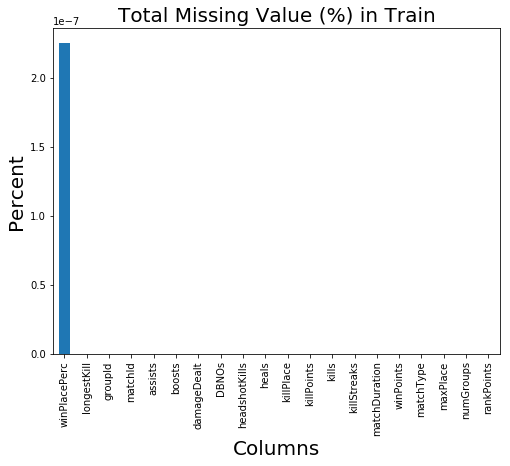

In [11]:
percent.head(20).plot(kind = 'bar', figsize = (8,6), fontsize = 10)
plt.xlabel('Columns', fontsize = 20)
plt.ylabel('Percent', fontsize = 20)
plt.title('Total Missing Value (%) in Train', fontsize = 20)

### Test

In [12]:
#test data에는 missing이 없음
test.isnull().sum().sort_values(ascending = False)

winPoints          0
weaponsAcquired    0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
Id                 0
dtype: int64

## Target Value(winPlacePerc)

In [13]:
train.winPlacePerc.describe()

count    4.446965e+06
mean              NaN
std      0.000000e+00
min      0.000000e+00
25%      1.999512e-01
50%      4.582520e-01
75%      7.407227e-01
max      1.000000e+00
Name: winPlacePerc, dtype: float64

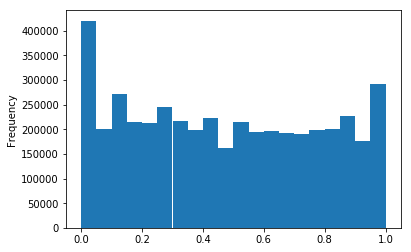

In [14]:
train.winPlacePerc.plot.hist(bins=20)

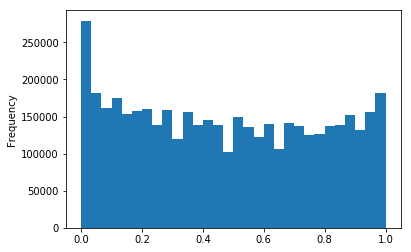

In [15]:
train.winPlacePerc.plot.hist(bins=30)

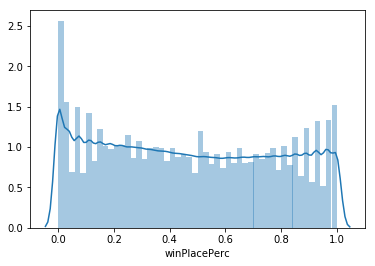

In [16]:
sns.distplot(train['winPlacePerc'].dropna())

In [17]:
k = 10 #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'winPlacePerc').index #winplacePerc와 가장 correlation 높은 변수 10개 선택

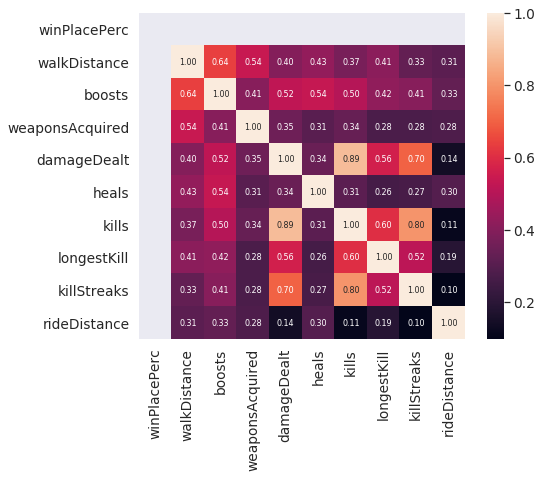

In [18]:
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)

f,ax = plt.subplots(figsize = (8,6))
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size' : 8}, yticklabels = cols.values,  xticklabels = cols.values)
plt.show()

## Others

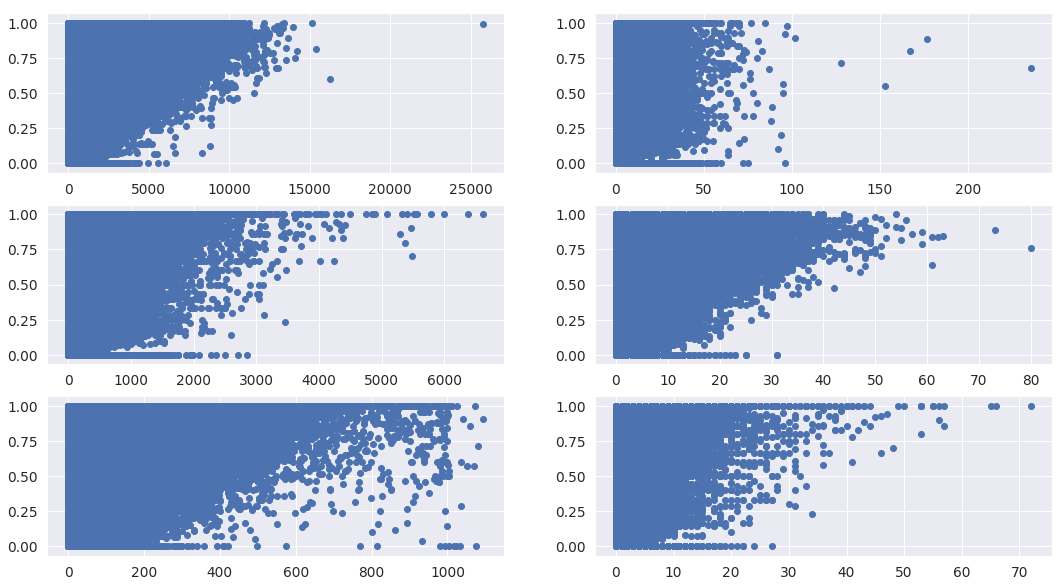

In [19]:
numeric_cols = ['walkDistance', 'weaponsAcquired', 'damageDealt','heals','longestKill','kills']
plt.figure(figsize = (18,10))

for i, col in enumerate(numeric_cols) :
    plt.subplot(3,2,i+1)
    plt.scatter(train[col], train['winPlacePerc'])

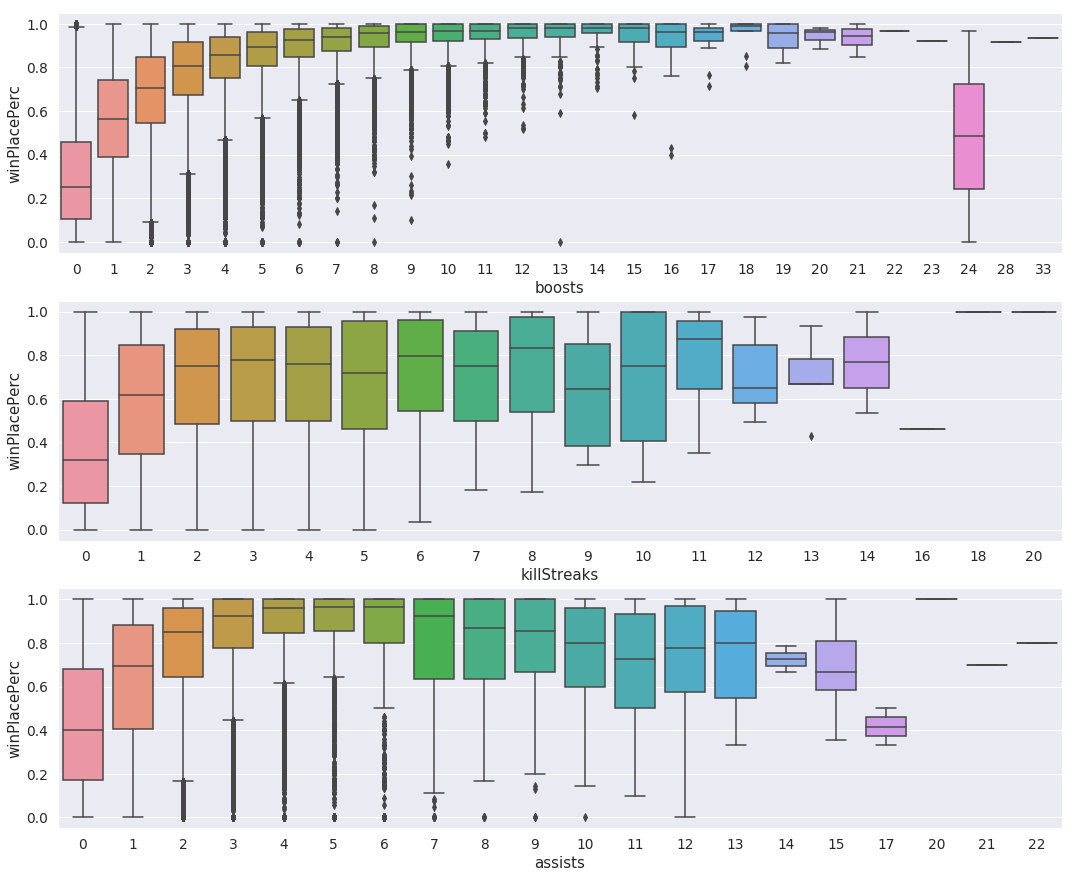

In [20]:
cat_cols = ['boosts','killStreaks','assists']
plt.figure(figsize = (18,15))
for i, col in enumerate(cat_cols) :
    plt.subplot(3,1,i+1)
    sns.boxplot(train[col], train['winPlacePerc'])

# Feature Engineering

## headshot rate

In [21]:
headshot = train[['kills','winPlacePerc','headshotKills']]
headshot['headshotrate'] = headshot['headshotKills'] / headshot['kills']
headshot.head()

,kills,winPlacePerc,headshotKills,headshotrate
0,0,0.444336,0,NaN
1,0,0.640137,0,NaN
2,0,0.775391,0,NaN
3,0,0.166748,0,NaN
4,1,0.187500,0,0.0


In [22]:
headshot.corr()

,kills,winPlacePerc,headshotKills,headshotrate
kills,1.000000,0.419915,0.674275,0.021278
winPlacePerc,0.419915,1.000000,0.277722,0.012416
headshotKills,0.674275,0.277722,1.000000,0.666980
headshotrate,0.021278,0.012416,0.666980,1.000000


In [23]:
del headshot

In [24]:
train['headshotrate'] = train['headshotKills'] / train['kills']
test['headshotrate'] = test['headshotKills'] / test['kills']

## killStreak rate

In [25]:
killStreak = train[['kills','winPlacePerc','killStreaks']]
killStreak['killStreaksrate'] = killStreak['killStreaks'] / killStreak['kills']
killStreak.corr()

,kills,winPlacePerc,killStreaks,killStreaksrate
kills,1.000000,0.419915,0.802500,-0.730883
winPlacePerc,0.419915,1.000000,0.377566,-0.386675
killStreaks,0.802500,0.377566,1.000000,-0.143883
killStreaksrate,-0.730883,-0.386675,-0.143883,1.000000


## healthitem

In [26]:
healthitem = train[['heals','winPlacePerc','boosts']]
healthitem['healthitems'] = healthitem['heals'] + healthitem['boosts']
healthitem.corr()

,heals,winPlacePerc,boosts,healthitems
heals,1.000000,0.427856,0.535854,0.927683
winPlacePerc,0.427856,1.000000,0.634232,0.575997
boosts,0.535854,0.634232,1.000000,0.812341
healthitems,0.927683,0.575997,0.812341,1.000000


In [27]:
del killStreak, healthitem
gc.collect()

32575

In [28]:
def feature_engineering(is_train=True,debug=True):
    test_idx = None
    if is_train: 
        print("processing train.csv")
        if debug == True:
            df = pd.read_csv('../input/train_V2.csv', nrows=10000)
        else:
            df = pd.read_csv('../input/train_V2.csv')           

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = pd.read_csv('../input/test_V2.csv')
        test_idx = df.Id
    
    # df = reduce_mem_usage(df)
    #df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    
    # df = df[:100]
    
    print("remove some columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    
    features.remove("matchType")
    
    # matchType = pd.get_dummies(df['matchType'])
    # df = df.join(matchType)    
    
    y = None
    
    
    if is_train: 
        print("get target")
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    # print("get group sum feature")
    # agg = df.groupby(['matchId','groupId'])[features].agg('sum')
    # agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    # df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    # df_out = df_out.merge(agg_rank, suffixes=["_sum", "_sum_rank"], how='left', on=['matchId', 'groupId'])
    
    # print("get group sum feature")
    # agg = df.groupby(['matchId','groupId'])[features].agg('sum')
    # agg_rank = agg.groupby('matchId')[features].agg('sum')
    # df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    # df_out = df_out.merge(agg_rank.reset_index(), suffixes=["_sum", "_sum_pct"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    del agg_rank
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    # print("get match type feature")
    # agg = df.groupby(['matchId'])[matchType.columns].agg('mean').reset_index()
    # df_out = df_out.merge(agg, suffixes=["", "_match_type"], how='left', on=['matchId'])
    
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    del df
    
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = df_out
    
    feature_names = list(df_out.columns)

    del df_out, agg
    gc.collect()

    return X, y, feature_names, test_idx
x_train, y_train, train_columns, _ = feature_engineering(True,False)
x_test, _, _ , test_idx = feature_engineering(False,True)

processing train.csv
remove some columns
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature
processing test.csv
remove some columns
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [29]:
x_train['headshotrate'] = x_train['headshotKills']/x_train['kills']
x_test['headshotrate'] = x_test['headshotKills']/x_test['kills']

x_train['killStreakrate'] = x_train['killStreaks']/x_train['kills']
x_test['killStreakrate'] = x_test['killStreaks']/x_test['kills']

x_train['healthitems'] = x_train['heals'] + x_train['boosts']
x_test['healthitems'] = x_test['heals'] + x_test['boosts']

del x_train['heals']; del x_test['heals']

train_columns.append('headshotrate')
train_columns.append('killStreakrate')
train_columns.append('healthitems')
train_columns.remove('heals')

In [30]:
print('train X shape : ', x_train.shape)
print('test X shape : ', x_test.shape)

train X shape :  (2026744, 172)
test X shape :  (1934174, 172)


In [31]:
x_train = reduce_mem_usage(x_train)
x_test = reduce_mem_usage(x_test)

Memory usage of dataframe is 2675.07 MB
Memory usage after optimization is: 622.38 MB
Decreased by 76.7%
Memory usage of dataframe is 2552.89 MB
Memory usage after optimization is: 592.11 MB
Decreased by 76.8%


# Modeling

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time
import lightgbm as lgb

In [33]:
folds = KFold(n_splits = 3, random_state = 0)
oof_preds = np.zeros(x_train.shape[0])
sub_preds = np.zeros(x_test.shape[0])

valid_score = 0
feature_importance_df = pd.DataFrame()

In [34]:
start = time.time()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train, y_train)) :
    trn_x, trn_y = x_train.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train.iloc[val_idx], y_train[val_idx]
    
    train_data = lgb.Dataset(data = trn_x, label = trn_y)
    valid_data = lgb.Dataset(data = val_x, label = val_y)
    
    params = {'objective' : 'regression', 'metric' : 'mae', 'n_estimators' : 15000, 'early_stopping_rounds' : 100,
            'num_leaves' : 31, 'learning_rate' : 0.05, 'bagging_fraction' : 0.9,
            'bagging_seed' : 0, 'num_threads' : 4, 'colsample_bytree' : 0.7}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval = 1000)
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration = lgb_model.best_iteration)
    oof_preds[oof_preds > 1] = 1
    oof_preds[oof_preds < 0] = 0
    
    sub_pred = lgb_model.predict(x_test, num_iteration = lgb_model.best_iteration)
    sub_pred[sub_pred>1] = 1
    sub_pred[sub_pred<0] = 0
    sub_preds += sub_pred / folds.n_splits #3-fold를 돌면서 세 번의 결과가 모두 더해진다
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df['feature'] = train_columns
    fold_importance_df['importance'] = lgb_model.feature_importance()
    fold_importance_df['fold'] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    gc.collect()
    
end = time.time()

print('Take Time : ', (end -start))

Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.0295164	valid_1's l1: 0.0301534
[2000]	training's l1: 0.0283767	valid_1's l1: 0.0296925
[3000]	training's l1: 0.027559	valid_1's l1: 0.0294918
[4000]	training's l1: 0.0268707	valid_1's l1: 0.0293752
[5000]	training's l1: 0.0262629	valid_1's l1: 0.0292986
[6000]	training's l1: 0.0256951	valid_1's l1: 0.0292373
[7000]	training's l1: 0.0251609	valid_1's l1: 0.0292006
[8000]	training's l1: 0.0246943	valid_1's l1: 0.0291695
[9000]	training's l1: 0.0242481	valid_1's l1: 0.029144
Early stopping, best iteration is:
[9792]	training's l1: 0.0239018	valid_1's l1: 0.0291356
Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.0294984	valid_1's l1: 0.0302283
[2000]	training's l1: 0.0283428	valid_1's l1: 0.0297396
[3000]	training's l1: 0.0275388	valid_1's l1: 0.0295372
[4000]	training's l1: 0.0268609	valid_1's l1: 0.0294175
[5000]	training's l1: 0.0262376	valid_1's l1: 0.0293333
[

In [35]:
feature_importance_df.head()

,feature,importance,fold
0,assists_mean,288,1
1,boosts_mean,1244,1
2,damageDealt_mean,1952,1
3,DBNOs_mean,746,1
4,headshotKills_mean,385,1


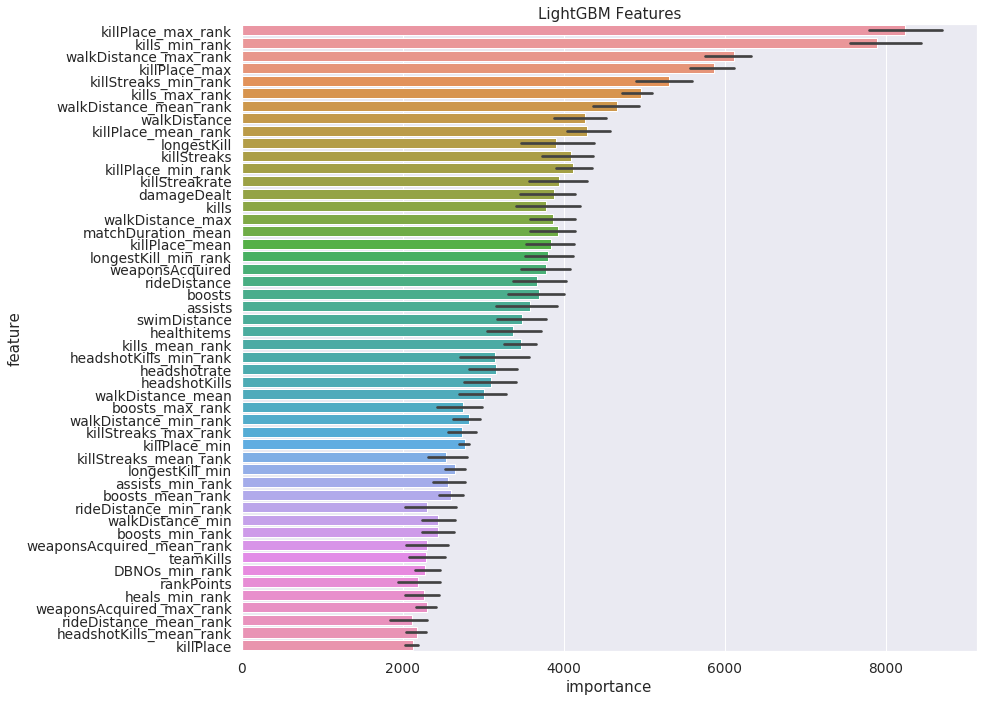

In [37]:
cols = feature_importance_df[['feature', 'importance']].groupby('feature').mean().sort_values(by = 'importance', ascending = False)[:50].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize = (14,10))
sns.barplot(x = 'importance', y = 'feature', data = best_features.sort_values(by = 'importance', ascending = False))
plt.title('LightGBM Features')
plt.tight_layout()

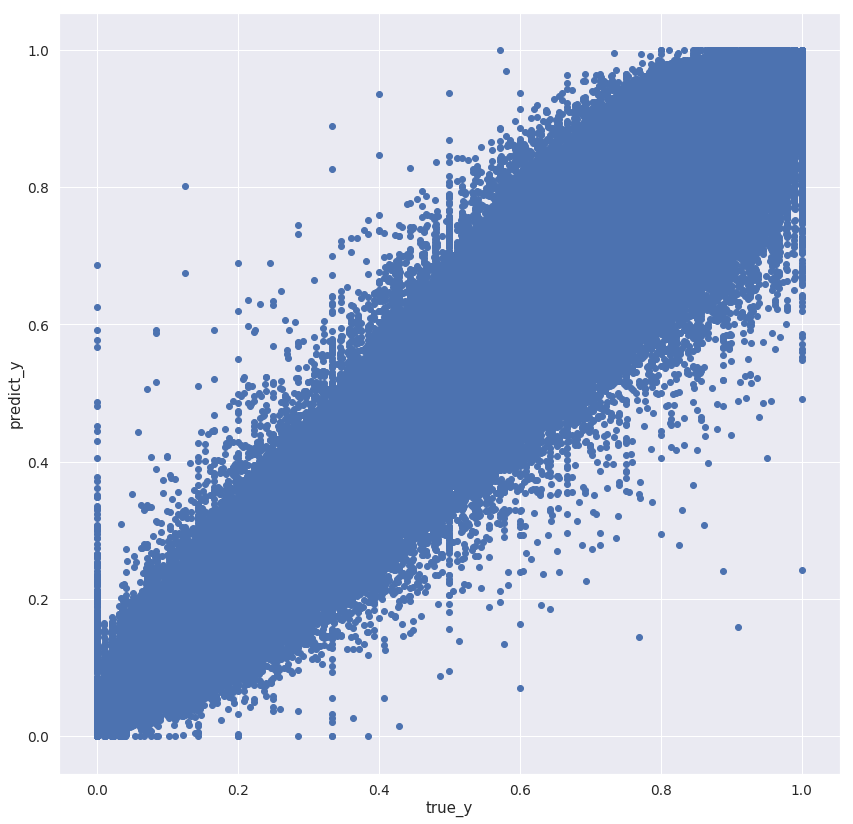

In [38]:
f, ax = plt.subplots(figsize = (14,14))
plt.scatter(y_train, oof_preds)
plt.xlabel('true_y')
plt.ylabel('predict_y')
plt.show()